<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style="border:2px solid black"> </hr>


**What?** How to cythonize your code



# What is cython?
<hr style="border:2px solid black"> </hr>


- What we commonly call Python is really two different things: the language and the implementation. 
    - The Python language defines the syntax (hence the language) with which we write code. 
    - The most common **implementation** is CPython (written in C and Python), which compiles valid Python code into bytecode and then interprets it in real time as the program runs.
- However, this flexibility has a cost, as it requires the interpreter to run a large number of tasks and checks behind the scenes at run time. 
- Cython is an attempt to bridge the gap by bringing some of C’s qualities to Python. Cython code mostly looks like Python code, but it also adds optional C-inspired syntax. Most notably, it allows us to declare static types when defining variables/classes/functions.
- Cython can automatically translate our code into C, which can then be then compiled into CPython extension modules. These compiled modules can be imported and used within Python code with significantly lower overhead than the equivalent Python modules.
- One of the reason’s for Python’s popularity is the flexibility afforded by its dynamic typing and memory management. 
    


# Fibonacci
<hr style="border:2px solid black"> </hr>


- `fib_py.py` is pure python implementation.

- `fib_py_cy.py` is identical to the pure python implementation and we'll cythonize it to compiled C code without making any manual changes.

- `fib_cy.pyx` is a pure cythonic implementation. Please note the ending `.pyx`.



In [6]:
!ls 

How to cythonize your code.ipynb fib_py.py
__pycache__                      fib_py_cy.py
fib_cy.pyx


# Cythonising
<hr style="border:2px solid black"> </hr>


- In order to run the Cython code, we first have to Cythonize it. 
- This involves two steps: 
    - Translating our Python-like code into C code
    - Compiling the C code into an executable. 



In [24]:
!pwd

/Users/gm_main/Desktop/DataScienceFolder/GitHub/High-Performance-Computing-in-Python/tutorials/cythonizing


In [17]:
!python setup_fibs.py build_ext --inplace

running build_ext
building 'fib_py_cy' extension
creating build
creating build/temp.macosx-10.9-x86_64-3.9
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/trainingAI/include -arch x86_64 -I/opt/anaconda3/envs/trainingAI/include -fPIC -O2 -isystem /opt/anaconda3/envs/trainingAI/include -arch x86_64 -I/opt/anaconda3/envs/trainingAI/include/python3.9 -c fib_py_cy.c -o build/temp.macosx-10.9-x86_64-3.9/fib_py_cy.o
creating build/lib.macosx-10.9-x86_64-3.9
clang -bundle -undefined dynamic_lookup -Wl,-rpath,/opt/anaconda3/envs/trainingAI/lib -L/opt/anaconda3/envs/trainingAI/lib -L/opt/anaconda3/envs/trainingAI/lib -Wl,-rpath,/opt/anaconda3/envs/trainingAI/lib -L/opt/anaconda3/envs/trainingAI/lib -arch x86_64 build/temp.macosx-10.9-x86_64-3.9/fib_py_cy.o -o build/lib.macosx-10.9-x86_64-3.9/fib_py_cy.cpython-39-darwin.so
building 'fib_cy' extension
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -f


- **Step #1** - First, Python checks which of our files has changed since the last Cythonization. 
- **Step #2** - Each of these is Cythonized, creating a *.c file. The C files are much longer and more complicated than the original Python file, or a true C implementation. The vast majority of this is specialized functions for interfacing between C and Python and handling various errors and exceptions.
- **Step #3** - Then each `*.c` file is compiled using gcc to create a `*.so` dynamic library, which is able to communicate directly with CPython at runtime (this may be a *.pyd file if you are using Windows without WSL). 
- Finally, the files are copied from the build/ directory to the working directory, where they can be imported by Python scripts.



In [23]:
!ls 

How to cythonize your code.ipynb fib_py.py
__pycache__                      fib_py_cy.c
build                            fib_py_cy.cpython-39-darwin.so
fib_cy.c                         fib_py_cy.html
fib_cy.cpython-39-darwin.so      fib_py_cy.py
fib_cy.html                      setup_fibs.py
fib_cy.pyx


# Cython and Python interaction
<hr style="border:2px solid black"> </hr>


- Because we have used the flag `annotate=True` a `*.html` annotation file s created.
- As stated in the file this shows the regions of the original Cython file based on how much Python interaction they require at runtime.
- The idea here is: less yellow line will bring less interaction with python hence less runtime.

- In the `fib_py_cy.c` file there is no static type information, and thus has significant interaction with the Python interpreter due to the need for dynamic type checking and memory management throughout the loop. 
- In the `fib_cy.c` file the only interacts with Python happens when calling and returning from the function; the internal computation of the loop is self-contained C code. 
    


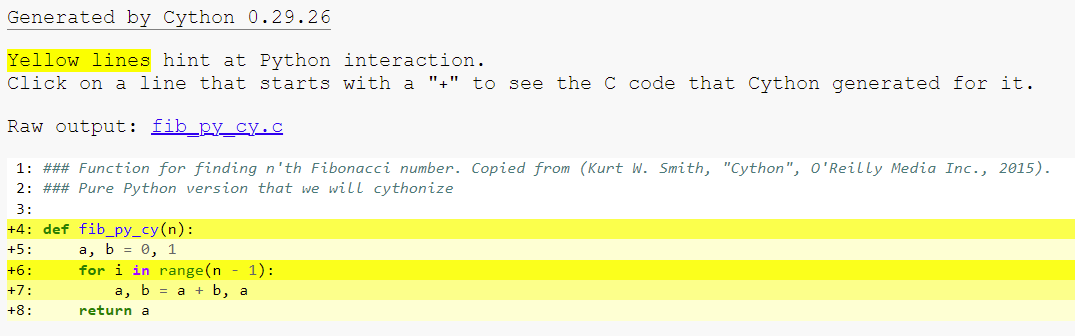

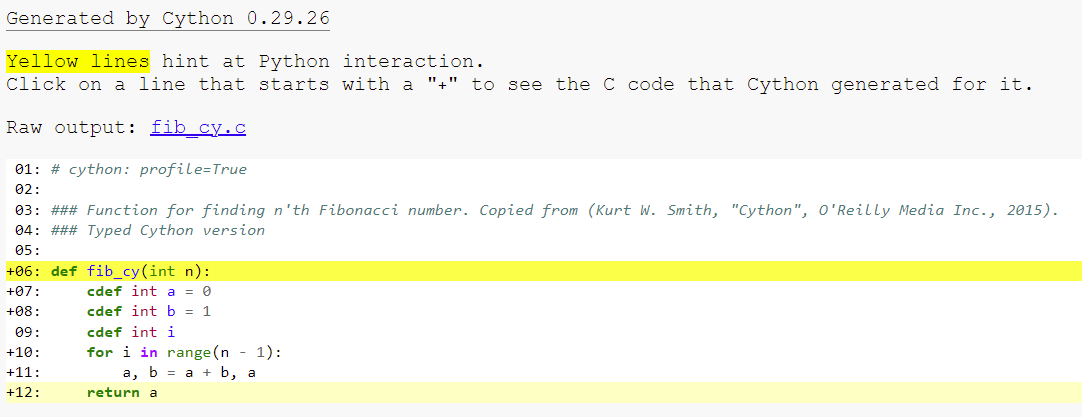

# Testing
<hr style="border:2px solid black"> </hr>

## Pure python

In [37]:
%%timeit
from fib_py import fib_py
#print(fib_py(30))

839 ns ± 5.86 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Cythonised python

In [35]:
%%timeit
from fib_py_cy import fib_py
#print(fib_py(30))

821 ns ± 5.81 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Pure Cython

In [38]:
%%timeit
from fib_cy import fib_cy
#print(fib_cy(30))

796 ns ± 1.86 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# No free lunch
<hr style="border:2px solid black"> </hr>


```
def fib_cy(int n):
    cdef int a = 0
    cdef int b = 1
    cdef int i # <<---
    for i in range(n - 1):
        a, b = a + b, a
    return a
```

- Notice how the answer produced by the typed Cython integer version is -811192543, rather than the correct answer of 7778742049. The reason for this is that Python3 integers can be unlimited size, while C integers can overflow if they get too big. 
- This fact would typically be accounted for when cythonising the whole code directly; notice how the Cythonized Python version got the correct answer). 
- However, in our static Cython code, these types of error checks are not performed. This shows that the speed advantages of Cython are not free – you do lose some of the flexibility & safety of Python, so some care is required. 



In [44]:
from fib_py import fib_py
print(fib_py(50))

7778742049


In [45]:
from fib_py_cy import fib_py
print(fib_py(50))

7778742049


In [46]:
print(fib_cy(50))

-811192543


# References
<hr style="border:2px solid black"> </hr>


- https://waterprogramming.wordpress.com/2022/06/29/cythonizing-your-python-code-part-1-the-basics/
- Kurt W. Smith’s O’Reilly Media book, “Cython: A Guide for Python Programmers“.

